# Polytop FDB Access: Polygon Feature Country Cutout

## Installation
See instruction in [Polytope installation](https://github.com/MeteoSwiss/nwp-fdb-polytope-demo/blob/main/README.md#Installation-1)

**Configuring Access to Polytope**

In [ ]:
import os
import dataclasses as dc
from meteodatalab import mars, mch_model_data

#ECMWF polytope credentials
# leave empty for ICON-CSCS polytope
os.environ["POLYTOPE_USER_KEY"] = ""
os.environ["POLYTOPE_USER_EMAIL"] = ""

#ICON-CSCS polytope credentials
# leave empty for ecmwf polytope
os.environ["POLYTOPE_USER_KEY"] = "xxxx"
os.environ["POLYTOPE_ADDRESS"] = "https://polytope-dev.mchml.cscs.ch"
os.environ["POLYTOPE_LOG_LEVEL"] = "INFO"

**Selecting date,time of the forecast**

In [ ]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 6
rounded_hour = (past_time.hour // 6) * 6
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time

**Extract the country polygon of Switzerland**

In [4]:
import earthkit.geo.cartography

shapes = earthkit.geo.cartography.country_polygons("Switzerland", resolution=50e6)

**Rotate the polygon points**

> **IMPORTANT**: `shapes` contains tuples of first latitude and then longitude. However, the function `transform_point`() expects first longitude and then latitude.

In [5]:
import cartopy.crs as ccrs

# South pole rotation of lon=10, latitude=-43
rotated_crs = ccrs.RotatedPole(
    pole_longitude=190, pole_latitude=43
)

# Convert a point from geographic to rotated coordinates
geo_crs = ccrs.PlateCarree()
rotated_points = [
    rotated_crs.transform_point(lon, lat, geo_crs)
    for lat, lon in shapes[0]
]

**Define the request**
> **IMPORTANT**: Don't forget to specify that the data points are tuples that first contain longitude and then latitude.

In [6]:
request = mars.Request(
    param="T_2M",
    date=date,
    time=time,
    model=mars.Model.ICON_CH1_EPS,
    levtype=mars.LevType.SURFACE,
    number=1,
    step=0,
    feature={
        "type" : "polygon",
        "shape" : rotated_points,
        "axes" : ["longitude", "latitude"] #first longitude, then latitude
    }
)

**Retrieve the data**

In [ ]:
import earthkit.data as ekd
ds = ekd.from_source(
    "polytope",
    "mchgj",
    request.to_polytope(),
    stream=False
).to_xarray()

**Rotate back to geo lat/lon**

In [8]:
unrotated_points = [
    geo_crs.transform_point(lon, lat, rotated_crs)
    for lon, lat in zip(ds.longitude,ds.latitude)
]

geo_lons, geo_lats = zip(*unrotated_points)

ds_geo = ds.assign_coords(
    longitude=("points", list(geo_lons)),
    latitude=("points", list(geo_lats))
)

**Convert to degree celsius**

In [9]:
da_geo = ds_geo['t_2m']
da_geo.values = da_geo.values - 273.15
da_geo.attrs['units'] = "°C"
da_geo.attrs['long_name'] = "2 Meter Temperature"

**Plot the data**

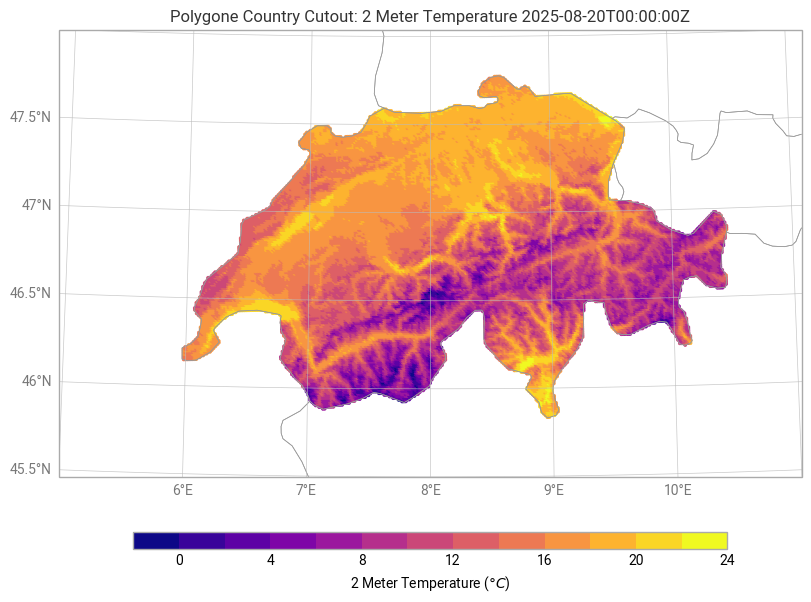

In [10]:
from earthkit.plots import Map
from earthkit.plots.geo import bounds, domains

xmin, xmax = 5, 11   # Longitude bounds
ymin, ymax = 45.5, 48   # Latitude bounds

bbox = bounds.BoundingBox(xmin, xmax, ymin, ymax, ccrs.Geodetic())
domain = domains.Domain.from_bbox(
    bbox=bbox,
    name="CH2"
)
chart = Map(domain=domain)
chart.point_cloud(da_geo, x="longitude", y="latitude")

chart.coastlines()
chart.borders()
chart.gridlines()


chart.title("Polygone Country Cutout: {long_name} {datetimes}")

chart.legend()

chart.show()